# HHAR (Heterogeneity Human Activity Recognition)
- 기기 간, 사용자 간의 이질성(Heterogeneity)를 연구하기 위해 만들어진 Dataset
- Phones: Nexus 4, LG G2, Galaxy S3, Galaxy S3 Mini, Galaxy S+ (각 2)
- Watch: LG G Watch, Samsung Gear Live (각 2개)
- 센서: acc, gyro
- 피험자: 9명
- 측정 위치: 스마트폰=허리 주변(여러대), 스마트워치= 양 손목(각각 다른 모델)
- Sampling Rate: 각 기기 최대 주파수로 기록 → 기기별로 50Hz~200Hz
---
- link: https://archive.ics.uci.edu/dataset/344/heterogeneity+activity+recognition
- 해당 dataset을 다운 받으면 3개 폴더
    1. `_MACOSX`: Mac에서 압축할 때 생성되는 임시 메타데이터(삭제)
    2. `Activity recognition exp`: Main DataSet
    3. `Still exp`: 정지상태 실험 데이터
---
- `Activity recognition exp/`\
    `Phones_accelerometer`, `Phones_gyroscope`, `Watch_accelerometer`, `Watch_gyroscope`
- Labels
    1. `Sit`
    2. `Stand`
    3. `Walk`
    4. `Bike`
    5. `Stairup`
    6. `Stairdown`

- Columns
    1. `Index`
    2. `Arrival_Time`: 데이터가 앱에 도착한 시간
    3. `Creation_Time`: 센서가 데이터를 생성한 시간
    4. `x/y/z`: 센서 측정값 (3축)
    5. `User`: 사용자 ID
    6. `Model`: 기기 모델명
    7. `Device`: 개별 기기의 고유 번호
    8. `gt`: Ground Truth (Labels)

- 주의 사항
    1. Sampling Rate가 제각각
        - dt를 직접 계산해서 실제 얼마나 다른지 확인해야함
    2. 기기별 센서 편향 존재
    3. 정확한 시계열 패턴을 보려면 Creation_Time을 보는 것이 원칙

- HHAR Workflow
    1. 로드 + 메타 구조 파악
    2. 타임스탬프/Δt로 sampling/세션 구조 확인
    3. 라벨/유저/디바이스/센서 분포 EDA
    4. sampling/정규화/도메인 split 전략 결정
    5. 세션 나누고 sliding window로 데이터 구조화
    6. train/val/test split + baseline 모델 학습/평가

- ***Q. 이 데이터셋의 장점? 특징이 다양한 Sampling Rate과 실생활에서 발생하는 Noise와 사람마다의 편차 등으로 모델의 generalizaion 능력을 확인하는 것에 있는데, raw data를 특정 Sampling rate으로 보정 혹은 고정해놓고 windowing해버리면 이게 무슨 의미일까?***\
  *A. HHAR의 “이질성”은 sampling rate 하나만이 아님. 기기 종류, 장착 위치/자세, subject별 편차, 노이즈/NAN/Drop 등등 \
  여기서 Resampling을 하는 이유도 일반적인 Model은 "등간격 시계열" 데이터를 가정하고 설계된다. continuous-time 모델(Neural ODE, CDE)을 따로 설계해야함.\
  A. 일반적인 HAR 벤치마크 관점에선 여전히 사람/기기/노이즈 차이는 크게 남아있기 때문에 데이터의 색깔을 완전히 잃는 것은 아님. Sampling Rate 자체에 Robust한 모델이 목표라면 Resample을 하지 않고 Test*


In [1]:
phone_acc_path = '/content/drive/MyDrive/Colab Notebooks/HAR_data/HHAR/Activity recognition exp/Phones_accelerometer.csv'
phone_gyro_path = '/content/drive/MyDrive/Colab Notebooks/HAR_data/HHAR/Activity recognition exp/Phones_gyroscope.csv'
watch_acc_path = '/content/drive/MyDrive/Colab Notebooks/HAR_data/HHAR/Activity recognition exp/Watch_accelerometer.csv'
watch_gyro_path = '/content/drive/MyDrive/Colab Notebooks/HAR_data/HHAR/Activity recognition exp/Watch_gyroscope.csv'

In [2]:
import pandas as pd
from pathlib import Path

root = Path('/content/drive/MyDrive/Colab Notebooks/HAR_data/HHAR/Activity recognition exp')

# 1) 개별 CSV 로드
phones_acc  = pd.read_csv(root / 'Phones_accelerometer.csv')
phones_gyro = pd.read_csv(root / 'Phones_gyroscope.csv')
watch_acc   = pd.read_csv(root / 'Watch_accelerometer.csv')
watch_gyro  = pd.read_csv(root / 'Watch_gyroscope.csv')

# 2) 센서/디바이스 타입 태그 추가
phones_acc['sensor'] = 'acc'
phones_gyro['sensor'] = 'gyro'
watch_acc['sensor'] = 'acc'
watch_gyro['sensor'] = 'gyro'

phones_acc['device_type'] = 'phone'
phones_gyro['device_type'] = 'phone'
watch_acc['device_type'] = 'watch'
watch_gyro['device_type'] = 'watch'

# 3) 하나의 long-format DataFrame으로 합치기
df = pd.concat([phones_acc, phones_gyro, watch_acc, watch_gyro], ignore_index=True)

df.head()


,Index,Arrival_Time,Creation_Time,x,y,z,User,Model,Device,gt,sensor,device_type
0,0,1424696633908,1424696631913248572,-5.958191,0.688065,8.135345,a,nexus4,nexus4_1,stand,acc,phone
1,1,1424696633909,1424696631918283972,-5.952240,0.670212,8.136536,a,nexus4,nexus4_1,stand,acc,phone
2,2,1424696633918,1424696631923288855,-5.995087,0.653549,8.204376,a,nexus4,nexus4_1,stand,acc,phone
3,3,1424696633919,1424696631928385290,-5.942718,0.676163,8.128204,a,nexus4,nexus4_1,stand,acc,phone
4,4,1424696633929,1424696631933420691,-5.991516,0.641647,8.135345,a,nexus4,nexus4_1,stand,acc,phone


In [3]:
# 전체 활동 분포
print(df['gt'].value_counts())

# 사용자별 활동 분포
print(df.groupby('User')['gt'].value_counts())

# 디바이스별 활동 분포
print(df.groupby('Device')['gt'].value_counts())

gt
walk          5580900
sit           5053949
bike          4915489
stand         4757110
stairsup      4586093
stairsdown    4204346
Name: count, dtype: int64
User  gt        
a     sit           653894
      stand         644590
      walk          589154
      bike          542325
      stairsdown    484414
      stairsup      483373
b     bike          726463
      walk          703943
      stairsup      578358
      sit           548737
      stand         541470
      stairsdown    488172
c     walk          638036
      sit           592747
      stairsup      572261
      stand         545756
      stairsdown    500856
      bike          488134
d     walk          700435
      sit           596547
      stand         579466
      stairsup      557707
      bike          480715
      stairsdown    422295
e     walk          721575
      bike          700703
      sit           616281
      stand         612766
      stairsup      526557
      stairsdown    513354
f     walk  

In [7]:
# 1) 우선 숫자형인지 확인하고 (문자열이면 astype 먼저)
df['Creation_Time'] = df['Creation_Time'].astype('int64')

# 2) ns 단위로 datetime 변환
df['Creation_Time_dt'] = pd.to_datetime(df['Creation_Time'], unit='ns')

# 3) 정렬
df = df.sort_values(['User', 'Device', 'Creation_Time_dt'])

# 4) Δt 계산 (초 단위)
df['dt'] = df.groupby(['User', 'Device'])['Creation_Time_dt'].diff().dt.total_seconds()

df['dt'].describe()

,dt
count,3.374139e+07
mean,8.645314e-03
std,2.254263e+01
min,0.000000e+00
25%,8.239740e-04
50%,4.127000e-03
75%,4.964000e-03
max,1.309318e+05


In [ ]:
'''
- 50%(중앙값) 0.004127초 = 약 242Hz -> 절반 이상의 sampling rate가 약 4.1ms정도 -> 대략 200~250Hz 영역의 디바이스가 많다는 의미
- 25%구간의 0.0008239초 = 약 1213Hz -> 실제 센서 주파수라기 보다는 TimeStamp가 거의 같은 sample들 -> dt가 너무 작은 값은
  '중복, 오류, 이벤트 밀집'등으로 보고 분석 시 제외
- Mean, STD는 이상치 때문에 거의 의미 없고, 중앙값 및 사분위수를 보는게 더 적절
'''

In [ ]:
'''
[Sampling Rate 정보를 알았으면 판단해야할 것]

(1) 그대로 windowing할지 resampling을 할지
    1. 디바이스별 rate 그대로 두고 time-based window만 사용
    2. 공통 Hz로 resample(interpolate|downsample)

(2) 정규화 방식
    1. global z-score
    2. per-device z-score

(3) split 방식
    1. user-wise
    2. device-wise
    3. User, Device 조합
'''

In [8]:
# 디바이스별 dt 정리

# 0) dt 이상치 제거 (0초, 너무 큰 gap 제거)
dt_clean = df['dt'].between(1e-4, 0.1)  # 0.0001s ~ 0.1s 사이만 사용
df_dt = df[dt_clean].copy()

# 1) Device별 dt 통계
device_dt = (
    df_dt.groupby('Device')['dt']
         .agg(median_dt='median', mean_dt='mean', count='size')
)

# 2) 초 → Hz로 변환
device_dt['hz_median'] = 1.0 / device_dt['median_dt']
device_dt['hz_mean']   = 1.0 / device_dt['mean_dt']

device_dt.sort_values('hz_median', ascending=False)


,median_dt,mean_dt,count,hz_median,hz_mean
Device,,,,,
nexus4_2,0.001617,0.002517,6295318,618.264014,397.289698
nexus4_1,0.001617,0.002518,6181268,618.264014,397.062585
s3_2,0.003660,0.003363,4740596,273.224044,297.363827
s3_1,0.003754,0.003367,4271076,266.382525,297.033098
s3mini_1,0.004914,0.005113,3078067,203.500204,195.561980
lgwatch_1,0.004944,0.004943,2593884,202.271591,202.304263
lgwatch_2,0.004974,0.005124,633147,201.030644,195.169854
s3mini_2,0.005921,0.006725,190578,168.890390,148.697811
gear_2,0.009929,0.010330,67453,100.715077,96.809194


In [13]:
df_dt = df[dt_clean].copy()
device_sensor_dt = (
    df_dt.groupby(['sensor'])['dt']
         .agg(median_dt='median', mean_dt='mean', count='size')
)
device_sensor_dt['hz_median'] = 1.0 / device_sensor_dt['median_dt']
device_sensor_dt['hz_mean']   = 1.0 / device_sensor_dt['mean_dt']
device_sensor_dt

,median_dt,mean_dt,count,hz_median,hz_mean
sensor,,,,,
acc,0.004303,0.006021,16595853,232.397137,166.086733
gyro,0.001563,0.002623,14063161,639.795266,381.269032


In [14]:
df_dt = df[dt_clean].copy()
device_sensor_dt = (
    df_dt.groupby(['Device', 'sensor'])['dt']
         .agg(median_dt='median', mean_dt='mean', count='size')
)
device_sensor_dt['hz_median'] = 1.0 / device_sensor_dt['median_dt']
device_sensor_dt['hz_mean']   = 1.0 / device_sensor_dt['mean_dt']
device_sensor_dt

median_dt   mean_dt    count    hz_median      hz_mean
Device       sensor                                                        
gear_1       acc      0.009941  0.010131   380227   100.593502    98.709075
             gyro     0.000141  0.000191     1818  7092.198582  5229.156719
gear_2       acc      0.009935  0.010374    67157   100.654253    96.392685
             gyro     0.000164  0.000203      296  6116.207951  4926.272343
lgwatch_1    acc      0.004944  0.004943  2576792   202.271591   202.304886
             gyro     0.004944  0.004945    17092   202.271591   202.210373
lgwatch_2    acc      0.004974  0.005118   514917   201.030644   195.398361
             gyro     0.004974  0.005150   118230   201.030684   194.180860
nexus4_1     acc      0.004272  0.004160  3089987   234.057194   240.371784
             gyro     0.000763  0.000877  3091281  1310.719060  1139.660264
nexus4_2     acc      0.004242  0.004159  3147081   235.740972   240.455346
             gyro     0.000763  0.000876  3148237  1310.719060  1141.635413
s3_1         acc      0.002499  0.002585  1402040   400.160064   386.860946
             gyro     0.004632  0.003749  2869036   215.889465   266.763484
s3_2         acc      0.002590  0.002675  1557672   386.100386   373.853264
             gyro     0.004610  0.003700  3182924   216.919740   270.299610
s3mini_1     acc      0.006318  0.005318  1539194   158.277936   188.044717
             gyro     0.003418  0.004909  1538873   292.568754   203.707058
s3mini_2     acc      0.005920  0.006778    95204   168.918919   147.538060
             gyro     0.005921  0.006672    95374   168.890390   149.873823
samsungold_1 acc      0.019928  0.016816  1113555    50.180650    59.467203
samsungold_2 acc      0.019928  0.016827  1112027    50.180650    59.428752

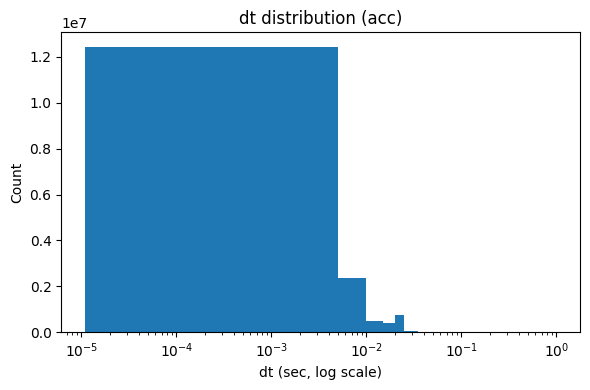

In [40]:
mask = df_acc['dt_sec'].between(1e-5, 1.0)  # 일단 10us~1s 정도만
dt_vals = df_acc.loc[mask, 'dt_sec']

plt.figure(figsize=(6,4))
plt.hist(dt_vals, bins=200)
plt.xscale('log')  # 1e-5 ~ 1e0까지 로그 스케일
plt.xlabel('dt (sec, log scale)')
plt.ylabel('Count')
plt.title('dt distribution (acc)')
plt.tight_layout()
plt.show()

In [ ]:
'''
acc는 대략 50/100/160/200/400 Hz 정도의 계층
gyro는 200~300 Hz + outliers(일부)
-> count가 적은 센서는 이상치에 취약하여 값이 튀는 것으로 보인다.
'''

In [16]:
df_acc = df[(df['sensor'] == 'acc')].copy()

# # 2) 타임스탬프를 datetime으로
df_acc['Creation_Time_dt'] = pd.to_datetime(df_acc['Creation_Time'], unit='ns')

# 3) 유저/디바이스/시간 기준으로 정렬
df_acc = df_acc.sort_values(['User', 'Device', 'Creation_Time_dt'])

# 4) 바로 이전 샘플과의 시간 차이를 초 단위로 계산
df_acc['dt_sec'] = (
    df_acc.groupby(['User', 'Device'])['Creation_Time_dt']
          .diff()
          .dt.total_seconds()
)

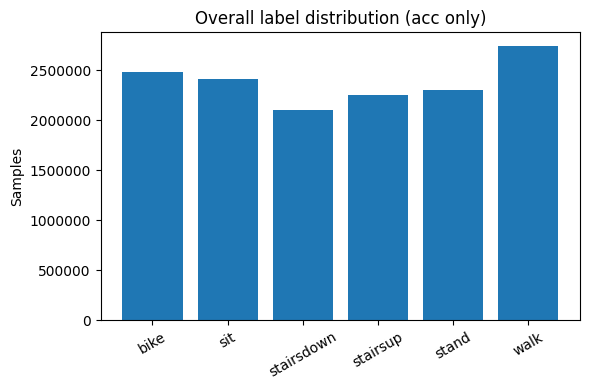

In [30]:
import matplotlib.pyplot as plt

label_counts = df_acc['gt'].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(label_counts.index, label_counts.values)
plt.title('Overall label distribution (acc only)')
plt.ylabel('Samples')
plt.xticks(rotation=30)
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

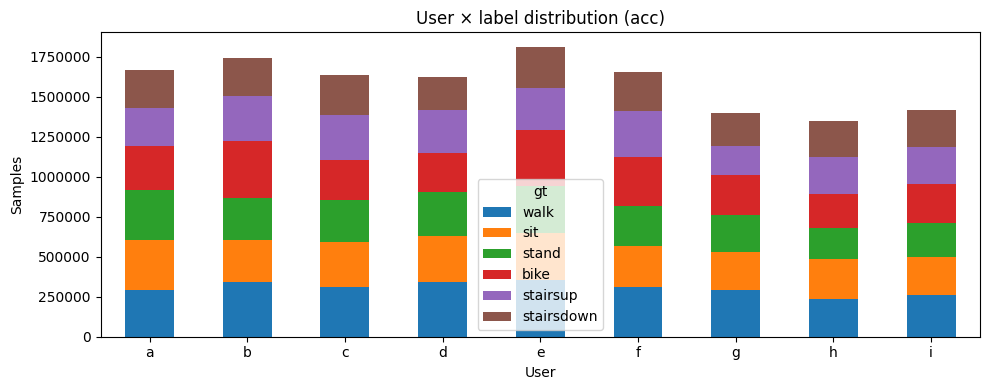

In [31]:
user_label = (
    df_acc.groupby(['User','gt'])
          .size()
          .unstack(fill_value=0)
          .loc[:, ['walk','sit','stand','bike','stairsup','stairsdown']]
)

user_label.plot(kind='bar', stacked=True, figsize=(10,4))
plt.title('User × label distribution (acc)')
plt.ylabel('Samples')
plt.xticks(rotation=0)
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

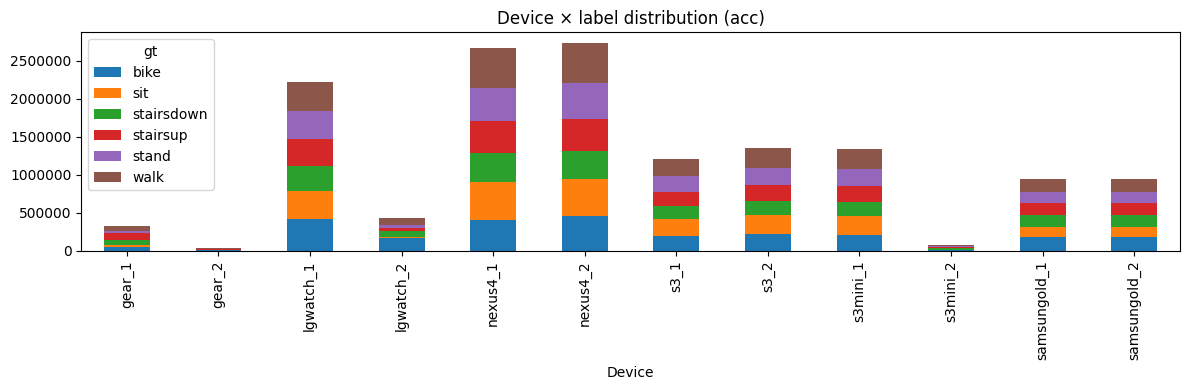

In [32]:
device_label = (
    df_acc.groupby(['Device','gt'])
          .size()
          .unstack(fill_value=0)
)

device_label.plot(kind='bar', stacked=True, figsize=(12,4))
plt.title('Device × label distribution (acc)')
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

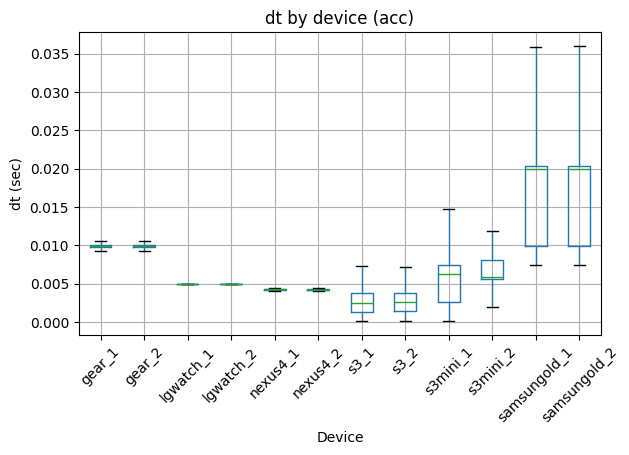

In [21]:
# 이상치 줄이려고 0 < dt_sec < 0.1만 사용
mask = df_acc['dt_sec'].between(1e-4, 0.1)
tmp = df_acc[mask].copy()

plt.figure(figsize=(10,4))
tmp.boxplot(column='dt_sec', by='Device', showfliers=False, rot=45)
plt.ylabel('dt (sec)')
plt.title('dt by device (acc)')
plt.suptitle('')
plt.tight_layout()
plt.show()

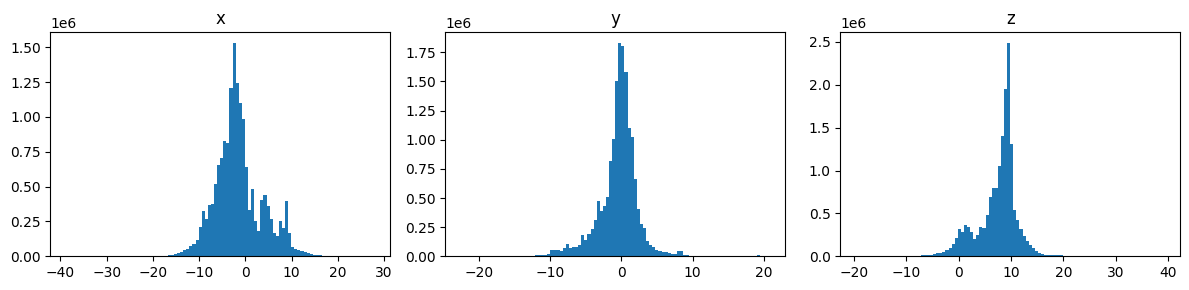

In [22]:
plt.figure(figsize=(12,3))
for i, axis in enumerate(['x','y','z']):
    plt.subplot(1,3,i+1)
    plt.hist(df_acc[axis], bins=100)
    plt.title(axis)
plt.tight_layout()
plt.show()

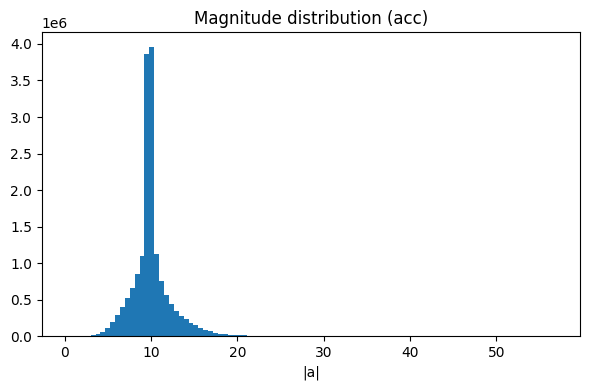

In [24]:
import numpy as np

df_acc['mag'] = np.sqrt(df_acc['x']**2 + df_acc['y']**2 + df_acc['z']**2)

plt.figure(figsize=(6,4))
plt.hist(df_acc['mag'], bins=100)
plt.title('Magnitude distribution (acc)')
plt.xlabel('|a|')
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

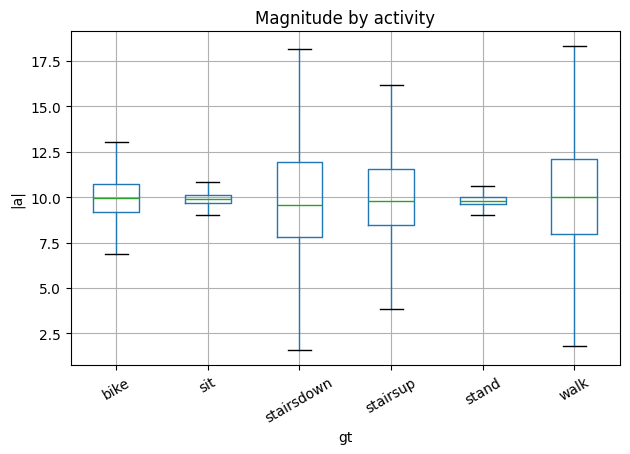

In [25]:
plt.figure(figsize=(8,4))
df_acc.boxplot(column='mag', by='gt', showfliers=False)
plt.title('Magnitude by activity')
plt.suptitle('')
plt.ylabel('|a|')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [33]:
# 활동 순서 고정 (데이터에 없는 건 자동으로 스킵)
ACT_ORDER = ["walk", "stairsup", "stairsdown", "bike", "sit", "stand"]

def plot_device_all_activities(df_acc, device, user=None, n_samples=800):
    """
    특정 Device(옵션: User까지 지정)에 대해
    각 activity별 예시 파형(x,y,z)을 subplot으로 그려줌.
    """
    df_dev = df_acc[df_acc["Device"] == device].copy()
    if user is not None:
        df_dev = df_dev[df_dev["User"] == user].copy()

    # 시간 정렬
    df_dev = df_dev.sort_values("Creation_Time_dt")

    # 실제로 존재하는 활동만 사용
    acts = [a for a in ACT_ORDER if a in df_dev["gt"].unique()]
    n_act = len(acts)

    plt.figure(figsize=(10, 2.5 * n_act))

    for i, act in enumerate(acts, start=1):
        g = df_dev[df_dev["gt"] == act].head(n_samples).copy()
        if len(g) == 0:
            continue

        # 0초부터 시작하는 상대시간 (초)
        t = (g["Creation_Time_dt"] - g["Creation_Time_dt"].iloc[0]).dt.total_seconds()

        plt.subplot(n_act, 1, i)
        plt.plot(t, g["x"], label="x")
        plt.plot(t, g["y"], label="y")
        plt.plot(t, g["z"], label="z")
        plt.title(f"{device} - {act} (N={len(g)})")
        if i == n_act:
            plt.xlabel("Time (sec)")
        plt.ylabel("acc")
        plt.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()

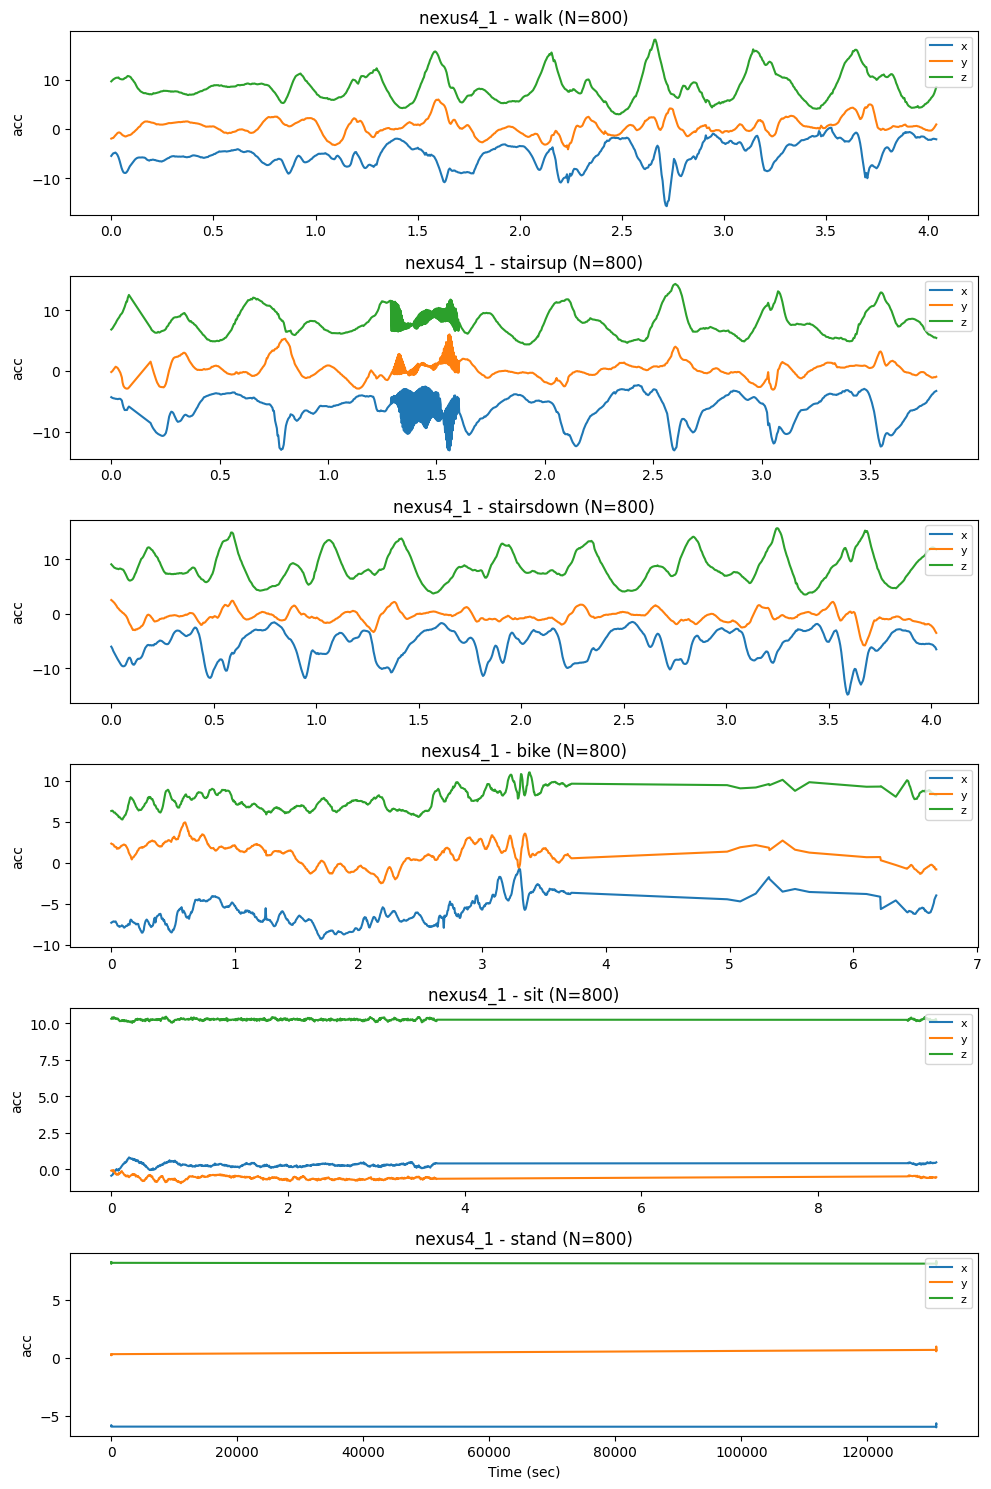

In [34]:
plot_device_all_activities(df_acc, device="nexus4_1", user="a", n_samples=800)

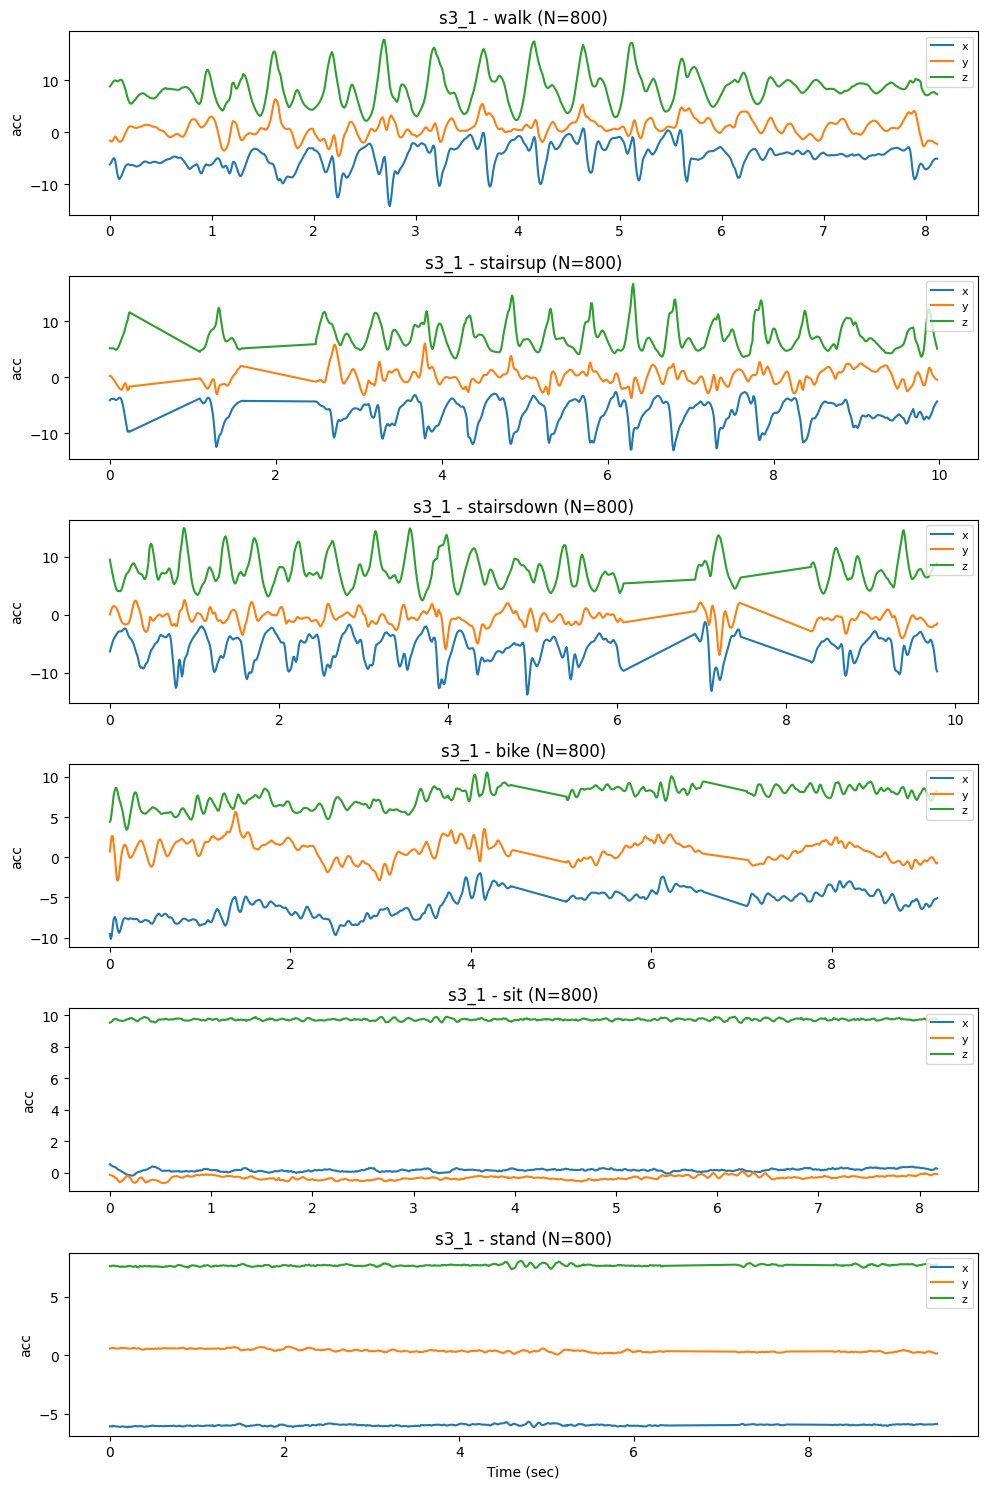

In [35]:
plot_device_all_activities(df_acc, device="s3_1", user="a", n_samples=800)

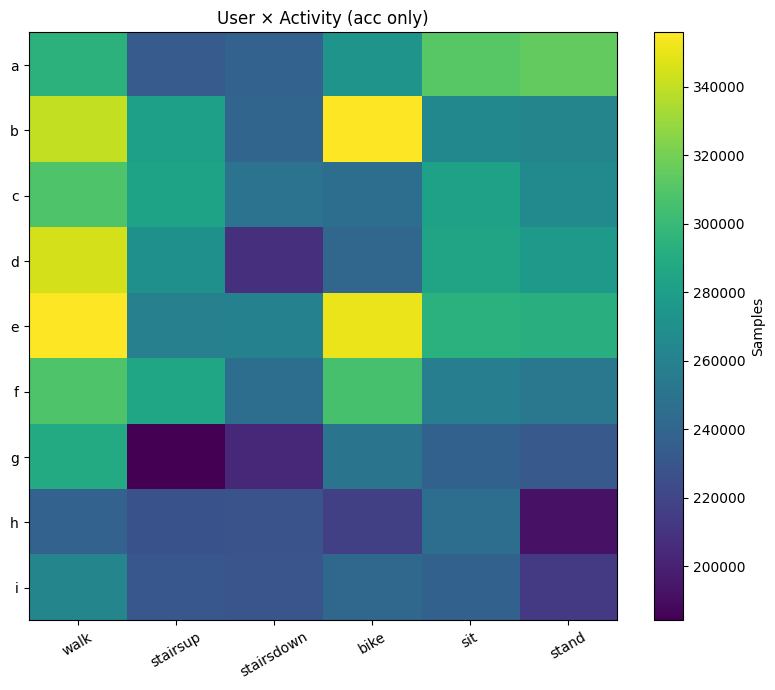

In [38]:
user_label = (
    df_acc.groupby(['User', 'gt'])
          .size()
          .unstack(fill_value=0)
          .loc[:, ["walk","stairsup","stairsdown","bike","sit","stand"]]
)

plt.figure(figsize=(8,7))
plt.imshow(user_label.values, aspect='auto')
plt.colorbar(label='Samples')
plt.xticks(range(user_label.shape[1]), user_label.columns, rotation=30)
plt.yticks(range(user_label.shape[0]), user_label.index)
plt.title('User × Activity (acc only)')
plt.tight_layout()
plt.show()

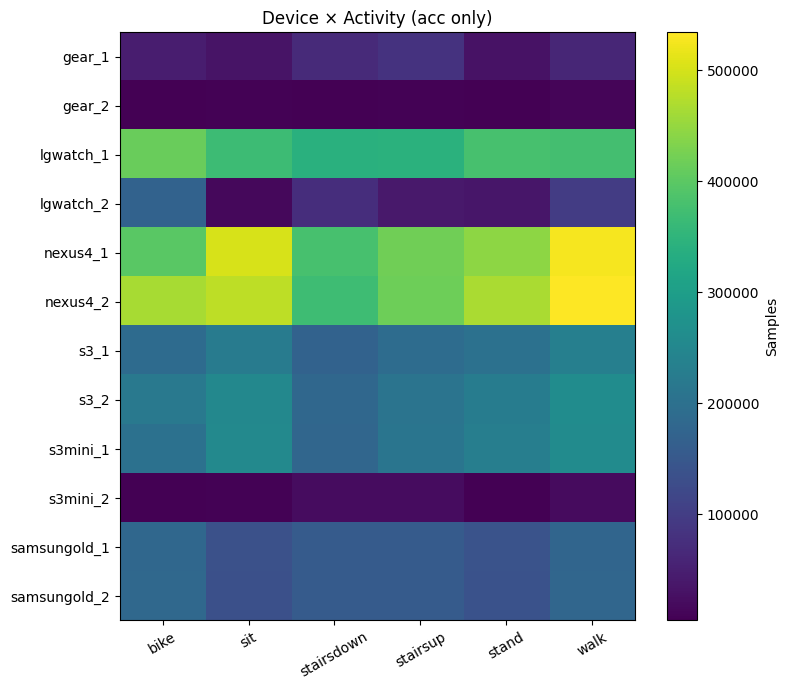

In [41]:
device_label = (
    df_acc.groupby(['Device', 'gt'])
          .size()
          .unstack(fill_value=0)
)

plt.figure(figsize=(8,7))
plt.imshow(device_label.values, aspect='auto')
plt.colorbar(label='Samples')
plt.xticks(range(device_label.shape[1]), device_label.columns, rotation=30)
plt.yticks(range(device_label.shape[0]), device_label.index)
plt.title('Device × Activity (acc only)')
plt.tight_layout()
plt.show()

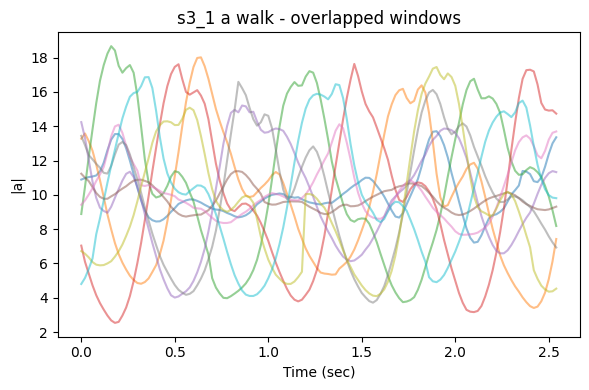

In [47]:
FS = 50  # 대충 50Hz라고 가정 (또는 실제 median Hz 써도 됨)
WINDOW_SEC = 2.56
WIN = int(WINDOW_SEC * FS)

activity = "walk"
device  = "s3_1"
user    = "a"

g = df_acc[
    (df_acc['gt'] == activity) &
    (df_acc['Device'] == device) &
    (df_acc['User'] == user)
].sort_values('Creation_Time_dt').reset_index(drop=True)

t = np.arange(WIN) / FS

plt.figure(figsize=(6,4))
max_windows = 10  # 너무 많지 않게

for start in range(0, len(g) - WIN, WIN):
    if max_windows <= 0:
        break
    w = g.iloc[start:start+WIN]
    plt.plot(t, w['mag'].to_numpy(), alpha=0.5)
    max_windows -= 1

plt.title(f'{device} {user} {activity} - overlapped windows')
plt.xlabel('Time (sec)')
plt.ylabel('|a|')
plt.tight_layout()